<h1>Principal Component Analysis</h1>

In [19]:
import numpy as np
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
from scipy.stats import multivariate_normal
import warnings
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support
from prettytable import PrettyTable

<h2>Given Template</h2>

In [20]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [21]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [22]:
dirpath = './problem1-dataset'
X,y = load_data(dirpath)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


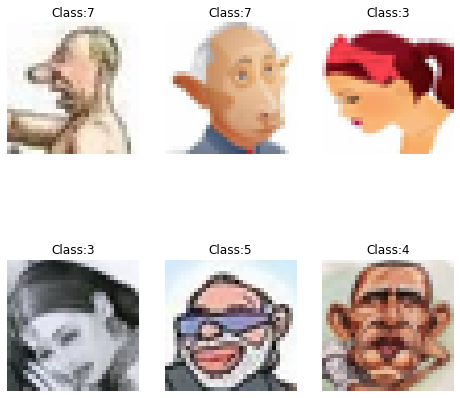

In [23]:
N,H,W = X.shape[0:3]
ind = np.random.randint(0,y.shape[0],6)
display_images(X[ind,...],y[ind], row=2,col=3)

<h2>My Code</h2>

In [24]:
"""
Converting the images into a 1 D array for PCA
"""

flattened_images = []

for image in X:
    flattened_images.append(image.flatten())
flattened_images = np.stack(flattened_images)

In [25]:
flattened_images.shape

(672, 3072)

In [26]:
data_points,features = flattened_images.shape

<h2>PCA Class</h2>

In [27]:
class PCA:
    
    """
    Standardize the data by subtracting respective means of features
    """
    
    def standardize(self,data_input):
        mean = np.mean(data_input,axis = 0)
        return data_input - mean
    
    """
    Extract the eigen values from X-transpose-X
    X-transpose-X => Covariance matrix
    """
    
    def eigenvalueExtraction(self,data_input):
        std_data = self.standardize(data_input)
        cov_matrix = np.matmul(std_data.T, std_data)
        eigen_vals, eigen_vectors = np.linalg.eig(cov_matrix)
        return std_data,eigen_vals,eigen_vectors
    
    """
    Select k eigen vectors for dimensionality reduction
    """
    
    def dimensionReduction(self,eig_val,eig_vec,k):
        return eig_val[:k],eig_vec[:,:k]
    
    """
    Reconstruction step for the scaled input data (normalized)
    """
    
    def reconstruction(self,scaled_X,eig_vec):
        return np.matmul(scaled_X,eig_vec)

    """
    Master function for applying PCA on a feature vector/vectors
    """
    
    def apply_pca(self,data,k=1):
        A, eigen_vals, eigen_vectors = self.eigenvalueExtraction(data)
        eigen_vals_red , eigen_vectors_red = self.dimensionReduction(eigen_vals,eigen_vectors,k)
        red_output_matrix = self.reconstruction(A,eigen_vectors_red)
        return A,eigen_vals,eigen_vectors,red_output_matrix

In [28]:
pca = PCA()

<h3>Plotting the cummulative variance vs number of PCs</h3>
<ul>
    <li> Variance in each feature (each PC) : Eigen Value</li>
    <li> Number of PC components (X axis) : PC</li>
</ul>

/tmp/ipykernel_218094/656483249.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  eigen_vals = np.asarray(eigen_vals, float)


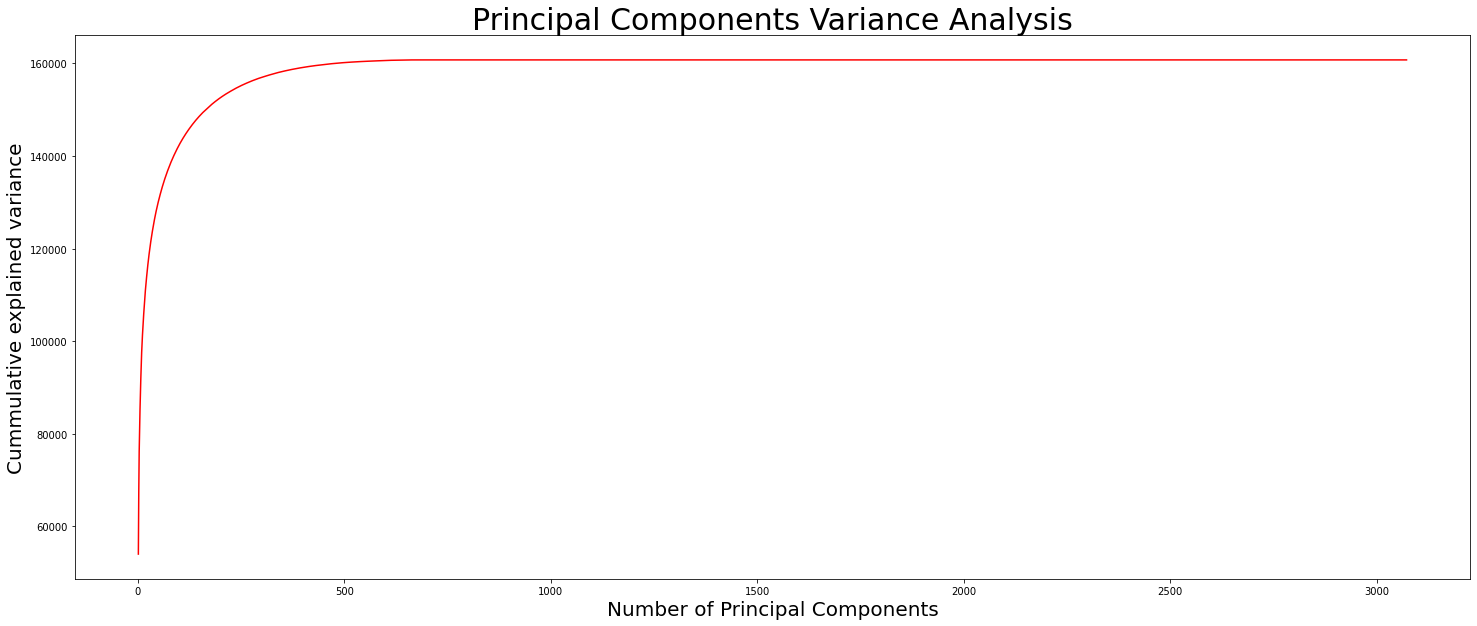

In [11]:
"""
BAR PLOT
"""

_,eigen_vals,_,_ = pca.apply_pca(flattened_images)

# discard imaginary component
eigen_vals = np.asarray(eigen_vals, float)

cummulative_var = np.zeros_like(eigen_vals)
sum_var=0

for i,eig in enumerate(eigen_vals):
    sum_var+=eig
    cummulative_var[i] = sum_var

plt.figure(figsize=(25,10))
plt.plot(np.linspace(1,eigen_vals.shape[0],eigen_vals.shape[0]),cummulative_var,color='r')
plt.xlabel('Number of Principal Components',fontsize=20)
plt.ylabel('Cummulative explained variance',fontsize=20)
plt.title('Principal Components Variance Analysis',fontsize=30)
plt.show()

<h1>Applying Dimensionality reduction on Pictionary dataset</h1>
<ul> 
    <li> Dimensionality Reduction </li>
    <li>Showing all the metrics of KNN Classifier after reduction </li>
</ul>

<h2> Before : Assignment 1 Code (Metrics for Pictionary Dataset)</h2> 

In [12]:
warnings.filterwarnings("ignore")

data = np.load(f'./data.npy',allow_pickle=True)

df = pd.DataFrame(data=data)
df[0] = np.arange(0,data.shape[0])

for i in range(data[:,2].shape[0]):
    data[:,2][i] = data[:,2][i].flatten()

for i in range(data[:,1].shape[0]):
    data[:,1][i] = data[:,1][i].flatten()

data = data[:,:4]

train = int(0.8*data.shape[0])
test = int(0.2*data.shape[0])

train_data = data[:train]
test_data = data[train:train+test]

class Distance():
    def __init__(self,k,dm):
        self.distance_metric_set = dm
        pass

    def Euclidean(self,v1,v2):
        return np.sqrt(np.sum((v1-v2)**2,axis=1))
    
    def Manhatten(self,v1,v2):
        return np.sum(np.abs(v1-v2),axis=1)
    
    def Cosine(self,v1,v2):
        return 1 - (np.dot(v1,v2)/(np.linalg.norm(v1,axis=1)*\
            np.linalg.norm(v2)))



mapper_lbl = {k:v for k,v in enumerate(list(np.unique(data[:,-1].flatten())),start=1)}
mapper_lbl_rev = {v:k for k,v in enumerate(list(np.unique(data[:,-1].flatten())),start=1)}

class KNNModel(Distance):
    
    mp_lbl = mapper_lbl
    mp_lbl_rev = mapper_lbl_rev
    
    def __init__(self,k,dm,enc_type,data):
        self.k = k
        self.data = data
        self.samples = data.shape[0]
        self.encoder_type=enc_type
        self.distance_metric = self.distance_metric_finder(dm)
        self.mapper_str_to_int_vectorize = np.vectorize(self.mapper_str_to_int)
                
    def distance_metric_finder(self,dm):
        if dm.lower() == "manhatten":
            return self.Manhatten
        if dm.lower() == "euclidean":
            return self.Euclidean
        if dm.lower() == "cosine":
            return self.Cosine
    
    def mapper_str_to_int(self,label):
        return KNNModel.mp_lbl_rev[label]


    def inference(self,test_samples):
        return_list = []
        
        collection_of_vectors = np.stack(self.data[:,self.encoder_type])
        for test_smpl in test_samples[:,self.encoder_type]:
            
            distances = self.distance_metric(collection_of_vectors,test_smpl)
            labels = self.mapper_str_to_int_vectorize(self.data[:,3])
            
            top_k = np.column_stack((distances, labels))
            
            top_k = top_k[np.argsort(distances)]
            top_k = top_k[:self.k]
            top_k = np.array(top_k)

            unique, counts = np.unique(top_k[:,1], return_counts=True)
            max_freq_count = np.max(counts)
            max_freq_labels = unique[counts == max_freq_count]
            resultant_shortlisted_neighbors = top_k[np.isin(top_k[:, 1], max_freq_labels)]
            return_list.append(resultant_shortlisted_neighbors[np.argmin(resultant_shortlisted_neighbors[:,0])][1])
            
        return return_list
    
    def validation_metrics_table(self,y_true,y_pred):
        a_macro = precision_recall_fscore_support(y_true,y_pred,average='macro')
        a_micro = precision_recall_fscore_support(y_true,y_pred,average='micro')
        a_weighted = precision_recall_fscore_support(y_true,y_pred,average='weighted')

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        myTable = PrettyTable(["Type","Accuracy","Precision","Recall","F1 - Score"])
        accuracy = round(np.sum(y_pred==y_true)/y_pred.shape[0],3)
        myTable.add_row(["Macro",accuracy,round(a_macro[0],3),round(a_macro[1],3),round(a_macro[2],3)])
        myTable.add_row(["Micro",accuracy,round(a_micro[0],3),round(a_micro[1],3),round(a_micro[2],3)])
        myTable.add_row(["Weighted",accuracy,round(a_weighted[0],3),round(a_weighted[1],3),round(a_weighted[2],3)])

        return myTable

model = KNNModel(10,"euclidean",2,train_data)
y_pred = []
y_true = []

outputs = model.inference(test_data)
y_pred = outputs
y_true = model.mapper_str_to_int_vectorize(test_data[:,3])

print("Without Dimensionaly Reduction")
print()
print("------------------------------")
print()
print(model.validation_metrics_table(y_true,y_pred))

Without Dimensionaly Reduction

------------------------------

+----------+----------+-----------+--------+------------+
|   Type   | Accuracy | Precision | Recall | F1 - Score |
+----------+----------+-----------+--------+------------+
|  Macro   |  0.307   |   0.215   | 0.209  |   0.189    |
|  Micro   |  0.307   |   0.307   | 0.307  |   0.307    |
| Weighted |  0.307   |   0.354   | 0.307  |   0.288    |
+----------+----------+-----------+--------+------------+


In [13]:
# Let K be the number of principal components
datapts_vit= np.stack(train_data[:,2])
datapts_resnet= np.stack(train_data[:,1])
accuracies = []
temporary_train_data = train_data.copy()
temporary_test_data = test_data.copy()

"""
Number of Principal components to test on : PC
"""
PC = 1000
# change


# We will be testing on the best model which is ViT type
for k in range(1,PC+1):
    # VIT
    _,_,_,dim_red = pca.apply_pca(np.vstack((np.stack(train_data[:,2]),np.stack(test_data[:,2]))),k=k)
    temporary_train_data[:,2] = list(dim_red[:train_data[:,2].shape[0]])
    temporary_test_data[:,2] = list(dim_red[train_data[:,2].shape[0]:])
    
    # ResNet
    _,_,_,dim_red = pca.apply_pca(np.vstack((np.stack(train_data[:,1]),np.stack(test_data[:,1]))),k=k)
    temporary_train_data[:,1] = list(dim_red[:train_data[:,1].shape[0]])
    temporary_test_data[:,1] = list(dim_red[train_data[:,1].shape[0]:])
                                  
    # feeding dimensionally reduced data features in ViT embeddings (best model previously)
    model = KNNModel(10,"euclidean",2,temporary_train_data)
    y_pred = []
    y_true = []

    outputs = model.inference(temporary_test_data)
    y_pred = np.array(outputs)
    y_true = model.mapper_str_to_int_vectorize(temporary_test_data[:,3])

    accuracy = round(np.sum(y_pred==y_true)/y_pred.shape[0],3)
    accuracies.append(accuracy)

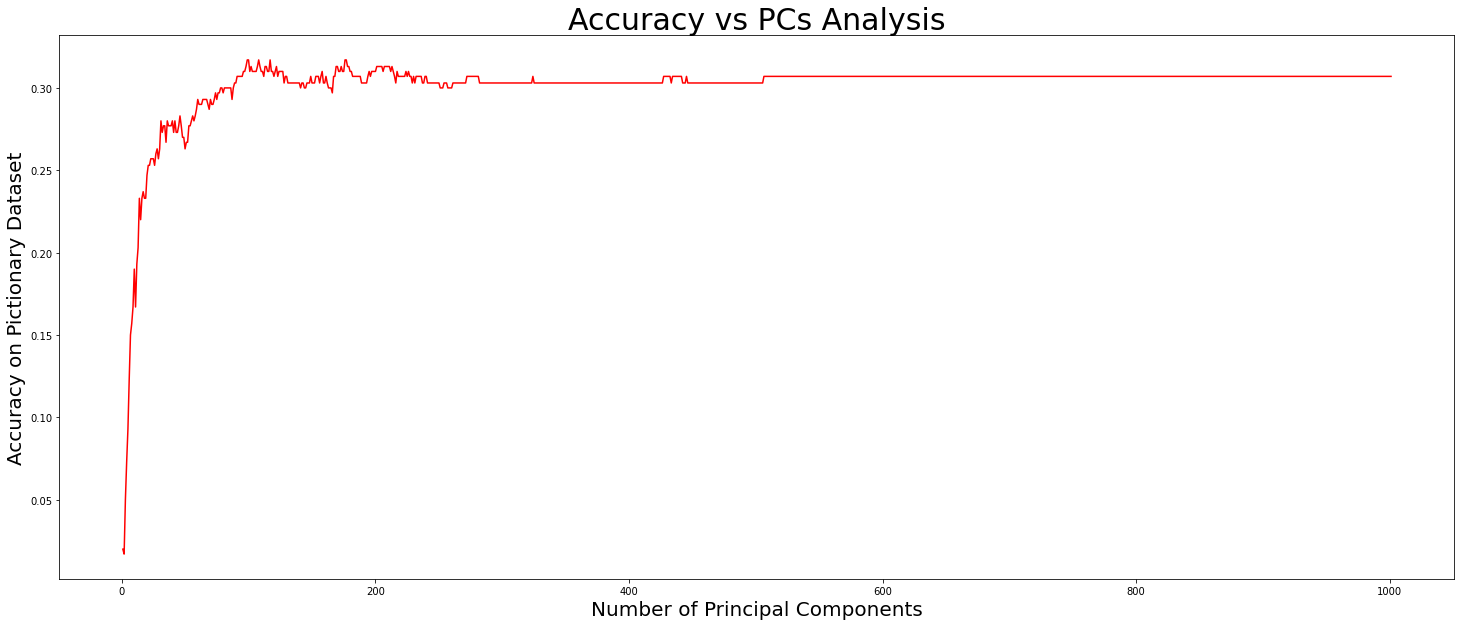

In [14]:
"""
BAR PLOT
"""

plt.figure(figsize=(25,10))
plt.plot(np.linspace(1,PC+1,PC),accuracies,color='r')
plt.xlabel('Number of Principal Components',fontsize=20)
plt.ylabel('Accuracy on Pictionary Dataset',fontsize=20)
plt.title('Accuracy vs PCs Analysis',fontsize=30)
plt.show()

# Observations:

1) PCA reduces the number of features in the dataset while retaining as much variance as possible. This can be particularly useful when we deal with high-dimensional data as in the case of Pictionary Dataset provided to us. Thus we observe that with fewer dimensions in the data generated after PCA, kNN calculations become comparatively quicker, as there are fewer features which have to be considered for generating the distances.

2) We see that in case the number of features after dimensional reduction is around 150-200 features which provide an accuracy > original feature length.

<h2>Pictionary Dataset</h2>

In [15]:
import pandas as pd
import numpy as np

In [16]:
# for drawer
df_drawer = pd.read_csv('./problem1-dataset2/drawer_attributes.csv')
df_drawer

,d_drawer,d_area_median,d_stroke_freq_median,d_rangestroketime_median,d_firststroketime_median,d_laststroketime_median,d_pcgamestup,d_pcgamestdown,d_pcgameserasehighlight
0,10,0.000000,0.000000,0.000,0.000,0.000,0.000000,0.000000,0.000000
1,36,82306.749763,0.578802,21.660,3.512,26.815,0.000000,0.000000,0.777778
2,14,60929.328432,0.239168,25.087,1.368,26.455,1.000000,1.000000,1.000000
3,26,119037.637976,0.402533,54.162,2.459,56.621,0.750000,0.500000,1.000000
4,40,0.000000,0.000000,0.000,0.000,0.000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
95,489,70962.506524,0.545814,27.828,4.873,34.187,0.200000,0.000000,0.400000
96,476,44293.554261,0.214476,24.361,2.619,26.980,0.250000,0.000000,0.500000
97,491,28575.130088,0.281468,31.310,3.671,37.586,0.153846,0.076923,0.461538
98,504,49562.212555,0.172661,40.626,10.302,47.306,0.400000,0.200000,0.400000


In [17]:
drawer = np.array(df_drawer)
drawer = drawer[:,1:]

In [18]:
guesser = np.array(df_guesser)
guesser = guesser[:,1:]

NameError: name 'df_guesser' is not defined

In [ ]:
# for guesser
df_guesser = pd.read_csv('./problem1-dataset2/guesser_attributes.csv')
df_guesser

In [ ]:
guesser.shape

In [ ]:
drawer.shape

In [ ]:
class PCA:
    
    """
    Standardize the data by subtracting respective means of features
    """
    
    def standardize(self,data_input):
        mean = np.mean(data_input,axis = 0)
        return data_input - mean
    
    """
    Extract the eigen values from X-transpose-X
    X-transpose-X => Covariance matrix
    """
    
    def eigenvalueExtraction(self,data_input):
        std_data = self.standardize(data_input)
        cov_matrix = np.matmul(std_data.T, std_data)
        eigen_vals, eigen_vectors = np.linalg.eig(cov_matrix)
        return std_data,eigen_vals,eigen_vectors
    
    """
    Select k eigen vectors for dimensionality reduction
    """
    
    def dimensionReduction(self,eig_val,eig_vec,k):
        return eig_val[:k],eig_vec[:,:k]
    
    """
    Reconstruction step for the scaled input data (normalized)
    """
    
    def reconstruction(self,scaled_X,eig_vec):
        return np.matmul(scaled_X,eig_vec)

    """
    Master function for applying PCA on a feature vector/vectors
    """
    
    def apply_pca(self,data,k=1):
        A, eigen_vals, eigen_vectors = self.eigenvalueExtraction(data)
        eigen_vals_red , eigen_vectors_red = self.dimensionReduction(eigen_vals,eigen_vectors,k)
        red_output_matrix = self.reconstruction(A,eigen_vectors_red)
        return A,eigen_vals,eigen_vectors,red_output_matrix

In [ ]:
pca = PCA()

In [ ]:
_,_,_,drawer_reduced_pca = pca.apply_pca(drawer,k=2)
_,_,_,guesser_reduced_pca = pca.apply_pca(guesser,k=2)

In [ ]:
print(drawer_reduced_pca.shape)
print(guesser_reduced_pca.shape)

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(25,12))

axs[0].set_title("Drawer projections after PCA",fontsize=20)
axs[0].scatter(drawer_reduced_pca[:,0],drawer_reduced_pca[:,1],s=60,color = 'g')

axs[0].set_xlabel('Principal Component 1',fontsize=15)
axs[0].set_ylabel('Principal Component 2',fontsize=15)

axs[1].set_title("Guesser projections after PCA",fontsize=20)
axs[1].scatter(guesser_reduced_pca[:,0],guesser_reduced_pca[:,1] , s=60,color = 'b')

axs[1].set_xlabel('Principal Component 1',fontsize=15)
axs[1].set_ylabel('Principal Component 2',fontsize=15)

In [ ]:
plt.show()

<h3>Points to note in the PCA of Pictionary Dataset</h3>
<ol>
    <li>The axes are denoted by the PC 1and PC2</li>
    <li>The above features are resuced from multidimensional space to 2D space <br>(8 for drawer and 6 for guesser)</li>
</ol>

# Observation

1) After PCA, PC1 i.e. the first principal component captures the most variance of data and indicates the direction in the feature space along which the data varies the most.
 
2) As the Principal components increase, each subsequent features are captured in decreasing amounts of variance.

3) PC2 captures the second most variance and is orthogonal to PC1. It is independent of PC1 and indicates the second-most important pattern or structure in the data. 